# Parameter Optimization Workflow with pyPESTO

---
---
This Jupyter notebook aims to demonstrate a comprehensive parameter optimization workflow for dynamical models. In this tutorial, we will explore the differences in complexity and efficiency that arise when performing parameter optimization with and without the use of pyPESTO.

The primary objectives of this notebook are twofold:

1. **General Workflow:** We will walk through a step-by-step process for parameter optimization of dynamical models. By following this workflow, you will gain a clear understanding of the essential steps involved and how they contribute to the overall optimization process.

2. **Benefits of pyPESTO:** Throughout the notebook, we will highlight the key advantages of using pyPESTO in each step of the workflow. pyPESTO is a powerful Python package specifically designed for parameter estimation and optimization tasks. By leveraging its capabilities, you can significantly enhance the efficiency and effectiveness of your parameter optimization tasks.


This notebook is divided into several sections, each focusing on a specific aspect of the parameter optimization workflow. Here's an overview of what you can expect to find in each section:


---
**Contents**

1. **Objective Function:** Here, we will discuss the creation of an appropriate objective function that quantifies the goodness-of-fit between a model and observed data. We will demonstrate how pyPESTO simplifies this process and provides various options for objective function definition.
2. **Parameter Estimation:** This section will cover the parameter estimation via optimization. We show the general workflow and and how pyPESTO eases the setup to be flexible for a variety of optimizers. We will also at analyzing and interpreting the obtained results. pyPESTO offers visualization and analysis tools that facilitate this task, and we will showcase their usefulness.
3. **Profiling:** In this section, we will explore the profiling capabilities of pyPESTO, which allow us to identify and optimize computationally expensive parts of the parameter optimization workflow.
4. **Sampling:** Here, we will delve into the sampling techniques, their setup for an optimization problem and how pyPESTO facilitates the process.
5. **Result Storage:** This section will focus on storing and organizing the results obtained from the parameter optimization workflow. We will explore the different options provided by pyPESTO for result storage.

---


By the end of this notebook, you will have gained valuable insights into the parameter optimization workflow for dynamical models. Moreover, you will have a clear understanding of the benefits that pyPESTO brings to each step of this workflow. This tutorial will equip you with the knowledge and tools necessary to streamline your parameter optimization tasks and obtain more accurate results.

In [3]:
# import
import logging
import os
import random
import tempfile
from pprint import pprint

import amici
import benchmark_models_petab as models
import matplotlib as mpl
import numpy as np
import petab
import scipy.optimize
from IPython.display import Markdown, display

import pypesto.optimize as optimize
import pypesto.petab
import pypesto.profile as profile
import pypesto.sample as sample
import pypesto.store as store
import pypesto.visualize as visualize
import pypesto.visualize.model_fit as model_fit

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 18

random.seed(1912)


# name of the model that will also be the name of the python module
model_name = "boehm_JProteomeRes2014"

# output directory
model_output_dir = "tmp/" + model_name

## 1. Create an objective function

The [Böhm et al. JProteomRes 2014](https://pubs.acs.org/doi/abs/10.1021/pr5006923) model, we will use in this notebook is a [PEtab](https://github.com/PEtab-dev/PEtab) model from the [PEtab Benchmark collection](https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab). For simulation purposes we will use [AMICI](https://github.com/AMICI-dev/AMICI). PEtab is a data format specification that standardises parameter estimation problems in systems biology. AMICI is a multi-language simulation tool for differential expression models specified in SBML format.

Loading the model via PEtab and AMICI already speeds up the whole workflow by leaps and bounds and is pretty straightforward:

In [4]:
%%capture
# PEtab problem loading
petab_yaml = f"./{model_name}/{model_name}.yaml"

petab_problem = petab.Problem.from_yaml(petab_yaml)

# AMICI model complilation
amici_model = amici.petab_import.import_petab_problem(
    petab_problem, force_compile=True
)

2023-07-14 12:24:39.814 - amici.petab_import - INFO - Importing model ...
2023-07-14 12:24:39.816 - amici.petab_import - INFO - Validating PEtab problem ...
2023-07-14 12:24:40.033 - amici.petab_import - INFO - Model name is 'FullModel'.
Writing model code to '/Users/pauljonasjost/Documents/GitHub_Folders/pyPESTO/doc/example/amici_models/FullModel'.
2023-07-14 12:24:40.035 - amici.petab_import - INFO - Species: 8
2023-07-14 12:24:40.037 - amici.petab_import - INFO - Global parameters: 15
2023-07-14 12:24:40.038 - amici.petab_import - INFO - Reactions: 9
2023-07-14 12:24:40.092 - amici.petab_import - INFO - Observables: 3
2023-07-14 12:24:40.093 - amici.petab_import - INFO - Sigmas: 3
2023-07-14 12:24:40.102 - amici.petab_import - DEBUG - Adding output parameters to model: ['noiseParameter1_pSTAT5A_rel', 'noiseParameter1_pSTAT5B_rel', 'noiseParameter1_rSTAT5A_rel']
2023-07-14 12:24:40.103 - amici.petab_import - DEBUG - Adding initial assignments for dict_keys([])
2023-07-14 12:24:40.125

AMICI allows us to construct an objective function from the PEtab problem, already considering the noise distribution assumed for this model. We can also simulate the problem for a parameter with this simple setup.

In [5]:
# Simulation with PEtab nominal parameter values
print("PEtab benchmark parameters")
pprint(amici.petab_objective.simulate_petab(petab_problem, amici_model))

# Simulation with specified parameter values
parameters = np.array([-1.5, -5.0, -2.2, -1.7, 5.0, 4.2, 0.5, 0.8, 0.5])
ids = list(amici_model.getParameterIds())
ids[6:] = ["sd_pSTAT5A_rel", "sd_pSTAT5B_rel", "sd_rSTAT5A_rel"]

print("Individualized parameters")
pprint(
    amici.petab_objective.simulate_petab(
        petab_problem,
        amici_model,
        problem_parameters={x_id: x_i for x_id, x_i in zip(ids, parameters)},
        scaled_parameters=True,
    )
)

PEtab benchmark parameters
{'edatas': [<Swig Object of type 'std::vector< amici::ExpData * >::value_type' at 0x13348bcf0
  condition 'model1_data1' starting at t=0.0 with custom parameter scales, constants, parameters
  16x3 time-resolved datapoints
    (48/48 measurements & 0/48 sigmas set)
  10x0 event-resolved datapoints
    (0/0 measurements & 0/0 sigmas set)
>],
 'llh': -138.22199656856435,
 'rdatas': [<ReturnDataView(<amici.amici.ReturnData; proxy of <Swig Object of type 'std::unique_ptr< amici::ReturnData >::pointer' at 0x1335bfa20> >)>],
 'sllh': None}
Individualized parameters
{'edatas': [<Swig Object of type 'std::vector< amici::ExpData * >::value_type' at 0x1334889c0
  condition 'model1_data1' starting at t=0.0 with custom parameter scales, constants, parameters
  16x3 time-resolved datapoints
    (48/48 measurements & 0/48 sigmas set)
  10x0 event-resolved datapoints
    (0/0 measurements & 0/0 sigmas set)
>],
 'llh': -185.54291970899519,
 'rdatas': [<ReturnDataView(<amici.

We can see, that to call the objective function, we need to supply the parameters in a dictionary format. This is not really suitable for parameter optimization. Therefore we need to create some kind of parameter mapping.

In [6]:
class objective:
    """
    A very basic implementation to an objective function for AMICI, that can call the objective function just based on the parameters.
    """

    def __init__(self, petab_problem: petab.Problem, model: amici.Model):
        """Constructor for objective."""
        self.petab_problem = petab_problem
        self.model = model
        self.x_ids = list(self.model.getParameterIds())
        # nned to change the names for the last ones
        self.x_ids[6:] = ["sd_pSTAT5A_rel", "sd_pSTAT5B_rel", "sd_rSTAT5A_rel"]

    def x_dct(self, x: np.ndarray):
        """
        Turn array of parameters to dictionary usable for objective call.
        """
        return {x_id: x_i for x_id, x_i in zip(self.x_ids, x)}

    def __call__(self, x: np.ndarray):
        """Call the objective function"""
        return -amici.petab_objective.simulate_petab(
            petab_problem,
            amici_model,
            problem_parameters=self.x_dct(x),
            scaled_parameters=True,
        )["llh"]


# Test it out
obj = objective(petab_problem, amici_model)
pprint(obj(parameters))

185.54291970899519


### Summary

We have a very basic functioning of an objective function for this specific problem. Some things that we have not yet considered and that will need additional code for are:
* As we can see, petab and amici are both very helpful already, but what if we do not have a model in PEtab format or do want to use something different than Amici? The amount of coding we would have to do would probably increase by a considerable amount.
* What if we have multiple simulation conditions? We would have to adjust the parameter mapping, be able to change parameters that we normal would not want to change etc.
* What if our system starts in a steady state? In this case we would have to preequilibrate, something that amici can do, but we would need to account for that additionally (and it would most likely also include an additional simulation condition).
* For later analysis we would like to be able to not only get the objective function but also the residuals, something that we can change in amici but we would have to account for this flexibility additionally.
* If we fix a parameter (for optimization), we would have to create a different parameter mapping (same for unfixing a parameter).
* We have a very basic objective function, what if we want to include prior knowledge of parameters?

This is most likely not the complete list but can already can get yield quite substantial coding effort. While each problem can be tackled, it is a lot of code lines, and we would need to rewrite it each time if we want to change something (or invest even more work and make the design of the objective function flexible).

In short: **There is a need for a tool, that can account for all these variables in the objective function formulation**

This is one of the things, pyPESTO takes care of for you. We support a multitude of objective functions (jax, aesara, amici, julia models, self written). For PEtab models with AMICI, we take care of the parameter mapping, multiple simulation conditions (incl. preequilibration), changing between residuals and objective function and fixing parameters.

While there is a lot of possibility for individualization, in its most basic form, creating an objective from a petab file accounting for all of the above, is boiled down to four lines in pyPESTO:

In [7]:
petab_yaml = f"./{model_name}/{model_name}.yaml"

petab_problem = petab.Problem.from_yaml(petab_yaml)
importer = pypesto.petab.PetabImporter(petab_problem)
problem = importer.create_problem()

problem.objective(parameters)

185.54291970899519

## 2. Optimization

After creating our objective function, we can now set up an optimization problem. For this we will need
* Parameter bounds
* startpoints for the multistart local optimization
* an optimizer

In [17]:
# bounds
ub = 3 * np.ones(len(parameters))
lb = -5 * np.ones(len(parameters))

# number of starts
n_starts = 4

# draw uniformly distributed parameters within these bounds
x_guesses = np.random.random((n_starts, len(lb))) * (ub - lb) + lb

# optimize
results = []
for x0 in x_guesses:
    results.append(
        scipy.optimize.minimize(
            obj,
            x0,
            bounds=zip(lb, ub),
            tol=1e-12,
            options={"maxfun": 500},
            method="L-BFGS-B",
        )
    )
pprint(results)

[  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: 235.14760253249028
        x: [-1.993e+00  5.348e-01 -4.877e+00  1.370e+00 -4.970e+00
             3.000e+00  1.620e+00  1.588e+00  1.300e+00]
      nit: 23
      jac: [-1.848e+01  5.192e+00 -3.586e+00  2.337e+00  1.234e+01
            -1.380e+01 -4.796e+00  1.376e-01  2.570e-01]
     nfev: 510
     njev: 51
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>,
   message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: 233.92094063157725
        x: [-4.824e+00  2.649e+00 -4.758e+00 -4.919e+00 -4.939e+00
             3.000e+00  1.530e+00  2.088e+00  9.758e-01]
      nit: 11
      jac: [ 7.318e+00  8.911e+01  2.765e+00  1.075e+02  3.747e+01
            -1.968e+01 -9.820e+00  3.315e+01 -7.564e+00]
     nfev: 560
     njev: 56
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>,
   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*E

This is smoothly running and does not take too much code. But again, we did not consider quite a few things regarding this problem:
* The Optimizer internally uses finite differences, which is inaccurate for very stiff models. Constructing sensitivities and integrating them into the optimization canbe quite tedious.
* There is no tracking of the history, we only get the end point. If we want to analyze this in more detail we need to implement this into the objective function.
* Many times, especcially for larger models, we might want to change the optimizer depending on the performance. A detailed analysis on this would require some setup.
* For bigger models and more starts, parallelization becomes a key component to ensure efficency. This was also not considered here.
* Especially when considering multiple optimizers, the lack of a quasi standardised result format becomes apparent und thus one would either have to write a proper result class or individualize all downstream analysis for each optimizer.

In [14]:
results_pypesto = optimize.minimize(
    problem=problem,
    optimizer=optimize.ScipyOptimizer(),
    n_starts=n_starts,
    engine=pypesto.engine.MultiProcessEngine(),
)
display(Markdown(results_pypesto.summary()))

Engine will use up to 8 processes (= CPU count).
100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


## Optimization Result 

* number of starts: 4 
* best value: 149.58816245414047, id=2
* worst value: 386.8475361953154, id=0
* number of non-finite values: 0

* execution time summary:
	* Mean execution time: 1.468s
	* Maximum execution time: 4.074s,	id=2
	* Minimum execution time: 0.092s,	id=0
* summary of optimizer messages:

  |   Count | Message                                         |
  |--------:|:------------------------------------------------|
  |       4 | CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH |

* best value found (approximately) 1 time(s)
* number of plateaus found: 1

A summary of the best run:

### Optimizer Result

* optimizer used: <ScipyOptimizer method=L-BFGS-B options={'maxfun': 1000, 'disp': False}>
* message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 
* number of evaluations: 161
* time taken to optimize: 4.074s
* startpoint: [-4.00247348  2.35675745 -3.97224376 -0.45702765 -2.4478275   0.97998309
  1.97011869 -0.76769131  4.25235683]
* endpoint: [-1.61857539  2.59927492  0.06608522 -1.58801737  5.          4.13592119
  0.93088504  0.69594878  0.5847842 ]
* final objective value: 149.58816245414047
* final gradient value: [-3.35139476e-04 -7.70631309e-04 -3.93828506e-05 -8.69338761e-05
 -1.09782993e-05 -6.15403452e-05 -2.32471761e-04 -1.51965117e-04
 -5.02761456e-05]


## Profiling

When it comes to profiling, we have the main apparatus already fleshed out with a working optimizer and our objective function. We still need a wrapper around the objective function as well as the geneal setup for the profiling, which includes selecting startpoints and cutoffs. For the sake of computation time, we will limit the maximum number of steps the scipy optimizer takes to 50.

In [33]:
# sort the results
results_sorted = sorted(results, key=lambda a: a["fun"])

# we optimimize the first parameter
x_start = results_sorted[0]["x"][1:]
x_fixed = results_sorted[0]["x"][0]
fval_min = results_sorted[0]["fun"]

# determine stepsize, ratios
stepsize = 0.05
ratio_min = 0.145
x_profile = [results_sorted[0]["x"]]
fval_profile = [results_sorted[0]["fun"]]

for direction, bound in zip([-1, 1], (-5, 3)):  # profile in both directions
    print(f"direction: {direction}")
    x0_curr = x_fixed
    x_rest = x_start
    run = True
    while direction * (x0_curr - bound) < 0 and run:
        x0_curr += stepsize * direction

        # define objective for fixed parameter
        def fix_obj(x: np.ndarray):
            x = np.insert(x, 0, x0_curr)
            return obj(x)

        res_step = scipy.optimize.minimize(
            fix_obj,
            x_rest,
            bounds=zip(lb[:-1], ub[:-1]),
            tol=1e-12,
            options={"maxfun": 50},
            method="L-BFGS-B",
        )
        # update profiles
        if direction == 1:
            x_profile.append(np.insert(res_step["x"], 0, x0_curr))
            fval_profile = np.append(fval_profile, res_step["fun"])
            if np.exp(fval_min - fval_profile[-1]) <= ratio_min:
                run = False
        if direction == -1:
            x_profile.insert(0, np.insert(res_step["x"], 0, x0_curr))
            fval_profile = np.insert(fval_profile, 0, res_step["fun"])
            if np.exp(fval_min - fval_profile[0]) <= ratio_min:
                run = False
        x_rest = res_step["x"]

direction: -1
	 next step
	 next step
	 next step
	 next step
direction: 1
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	 next step
	

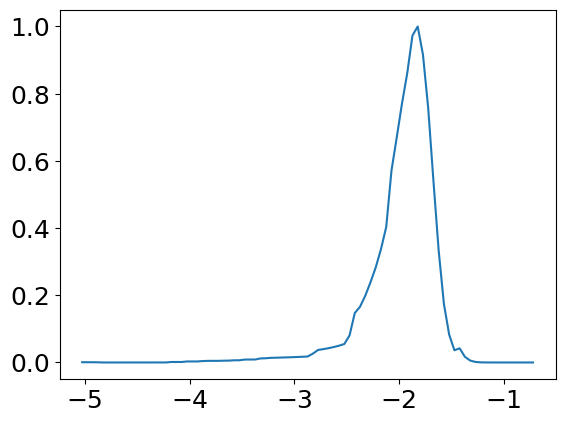

In [42]:
import matplotlib.pyplot as plt

plt.plot(
    [x[0] for x in x_profile], np.exp(np.min(fval_profile) - fval_profile)
);

This is a very basic implementation and again, we did not take into account the following things:
* If we want to profile all parameters, we will want to parallelize this to save time.
* We chose a very unflexible stepsize, in general we would want to be able to adjust this during the process.
* As this is still an optimization, the things discussed in the last step are also valid here in largest parts.

pyPESTO takes care of those things and integrates the profiling directly into the Result object

Engine will use up to 8 processes (= CPU count).
100%|██████████| 1/1 [00:11<00:00, 11.46s/it]


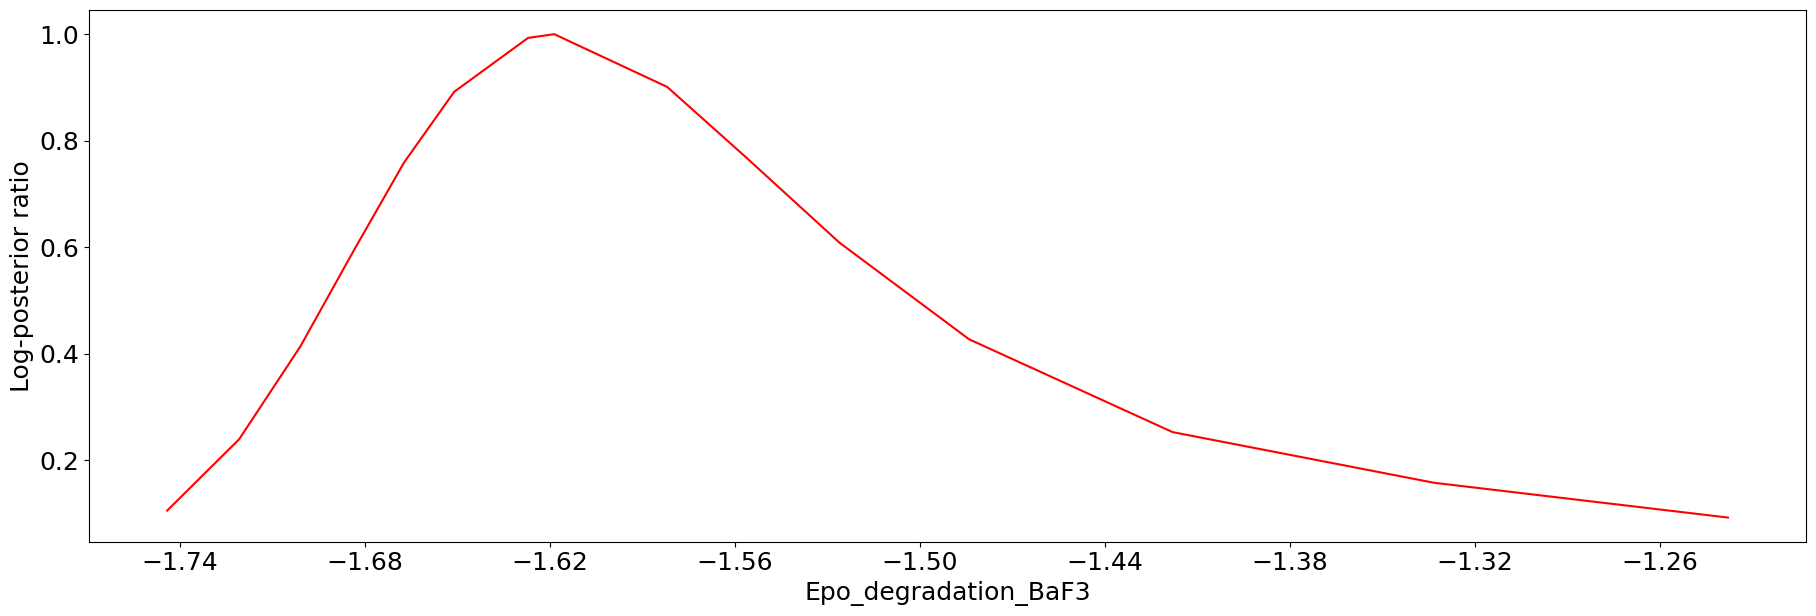

In [44]:
result = profile.parameter_profile(
    problem=problem,
    result=results_pypesto,
    optimizer=optimize.ScipyOptimizer(),
    engine=pypesto.engine.MultiProcessEngine(),
    profile_index=[0],
)

visualize.profiles(result);

## Sampling

pyPESTO also supports Bayesian sampling methods. These are used to retrieve posterior distributions and measure uncertainty. While there are many available sampling methods, setting them up for a more complex objective function can be time intensive and comparing different ones even more so.

In [ ]:
import emcee

n_samples = 1000


# set up the sampler
# rewrite nll to llh
def log_prob(x):
    """Log-probability density function."""
    # check if parameter lies within bounds
    if any(x < lb) or any(x > ub):
        return -np.inf
    # invert sign
    return -1.0 * obj(x)


sampler = emcee.EnsembleSampler(nwalkers=1, ndim=len(ub), log_prob_fn=log_prob)
self.sampler.run_mcmc(initial_state=self.state, nsteps=n_samples)